In [1]:
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import helper_functions.displayFunctions as display
import helper_functions.homogeneityMetrics as homogeneity

# Loading Predictions

In [2]:
with open('predictions/saved_predictions.pkl', 'rb') as f:
    results = pickle.load(f)

box_matches = pd.read_csv('data_out/object_detection/box_matches.csv', index_col=0)
participant_boxes = pd.read_csv('data/experiment_boxes.csv')

# Loading row

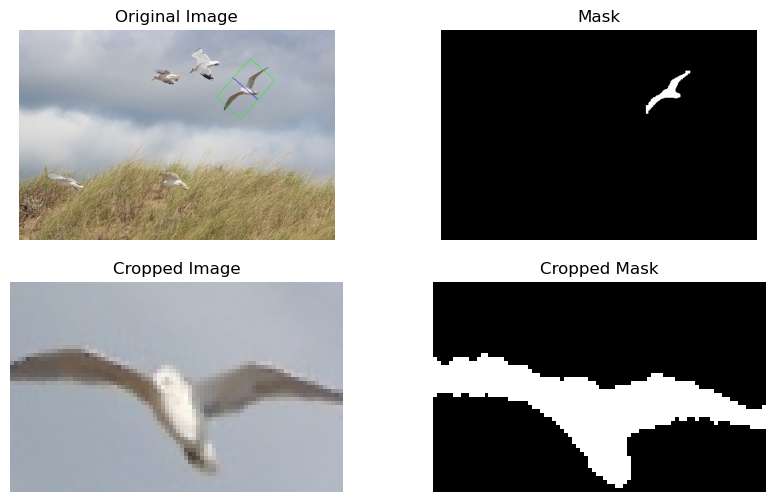

In [3]:
# image_name = 'MIRFLICKR25 - im12013.jpg' # 1 element
# image_name = 'COCO - 000000372250.jpg'     # 2 elements (0)
# image_name = 'CAT2000 -195.jpg'            # 0 elements

image_name = 'COCO - 000000150237.jpg'        #testing (3)

# image_name = 'COCO - 000000011336.jpg'
# image_name = 'COCO - 000000349425.jpg'

row_idx = 3

mask = results[image_name].masks[0].data.cpu().numpy()[0]
mask = cv2.resize(mask, (results[image_name].orig_shape[1], results[image_name].orig_shape[0]), interpolation=cv2.INTER_NEAREST).astype(np.uint8)

image = cv2.imread('images/images_nat/' + image_name)

df_image = participant_boxes[participant_boxes['file_name'] == image_name]
row = df_image.iloc[row_idx]

cropped_img = display.crop_image(image, row)
cropped_mask = display.crop_image(mask, row)

display_img = image.copy()
display.drawBB(display_img, row)

fig, ax = plt.subplots(2, 2, figsize=(10, 6))

ax[0, 0].imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(mask, cmap='gray')
ax[0, 1].set_title('Mask')
ax[0, 1].axis('off')

ax[1, 0].imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
ax[1, 0].set_title('Cropped Image')
ax[1, 0].axis('off')

ax[1, 1].imshow(cropped_mask, cmap='gray')
ax[1, 1].set_title('Cropped Mask')
ax[1, 1].axis('off')

plt.show()


# Homogeneity Series

We iteratively increase the size of the box by 1 pixel and record the homogeneities

In [4]:
def is_bbox_outside_image(row, img_shape):
    """
    Check if any point of the bounding box is outside the image boundaries.
    Parameters:
    row (pd.Series): A row from a DataFrame containing bounding box information.
    img_shape (tuple): A tuple representing the shape of the image (height, width).
    Returns:
    bool: True if any point of the bounding box is outside the image boundaries, False otherwise.
    """
    box_points = display.getBBPoints(row)
    for point in box_points:
        if point[0] < 0 or point[1] < 0 or point[0] > img_shape[1] or point[1] > img_shape[0]:
            return True
        
    return False

def get_homogeneity_series(mask, row):
    """
    Calculate various homogeneity metrics for a given mask and image row.
    Parameters:
    mask (numpy.ndarray): The binary mask to be used for calculations.
    row (pandas.Series): A row from a DataFrame containing image metadata, including 'file_name', 'width_box', and 'height_box'.
    Returns:
    dict: A dictionary containing lists of calculated homogeneity metrics:
        - 'rms': List of Root Mean Square (RMS) values.
        - 'glcm': List of Gray Level Co-occurrence Matrix (GLCM) values.
        - 'otsus': List of Otsu's thresholding method values.
        - 'edge_density': List of edge density values.
    """
    image = cv2.imread(display.getImgPath(row['file_name']))
    mask = cv2.bitwise_not(mask)
    mask -= 254
    
    rmss = []
    glcms = []
    otsus = []
    edge_densities = []

    row_copy = row.copy()

    while not is_bbox_outside_image(row_copy, image.shape):
        row_copy['width_box'] += 1
        row_copy['height_box'] += 1

        cropped_img = display.crop_image(image, row_copy)
        cropped_mask = display.crop_image(mask, row_copy)

        rmss.append(homogeneity.rms(cropped_img, cropped_mask))
        glcms.append(homogeneity.glcm(cropped_img, cropped_mask))
        otsus.append(homogeneity.otsus_method(image, cropped_mask, row_copy))
        edge_densities.append(homogeneity.edge_density(image, cropped_mask, row_copy))

    return {
        'rms': rmss,
        'glcm': glcms,
        'otsus': otsus,
        'edge_density': edge_densities
    }

def get_homogeneity_series_rmss_only(mask, row):
    """
    Calculate the Root Mean Square (RMS) homogeneity series for a given mask and row.
    This function reads an image based on the file name in the provided row, inverts the mask,
    and iteratively increases the bounding box dimensions to calculate the RMS homogeneity
    for each cropped image and mask until the bounding box is outside the image.
    Args:
        mask (numpy.ndarray): The binary mask to be processed.
        row (pandas.Series): A pandas Series containing the image metadata, including the file name
                             and bounding box dimensions.
    Returns:
        dict: A dictionary containing the RMS homogeneity series with the key 'rms'.
    """

    image = cv2.imread(display.getImgPath(row['file_name']))
    mask = cv2.bitwise_not(mask)
    mask -= 254
    
    rmss = []
    row_copy = row.copy()

    while not is_bbox_outside_image(row_copy, image.shape):
        row_copy['width_box'] += 1
        row_copy['height_box'] += 1

        cropped_img = display.crop_image(image, row_copy)
        cropped_mask = display.crop_image(mask, row_copy)

        rmss.append(homogeneity.rms(cropped_img, cropped_mask))

    return {
        'rms': rmss
    }

metrics = get_homogeneity_series(mask, row)

## Visualize results

### Graphs

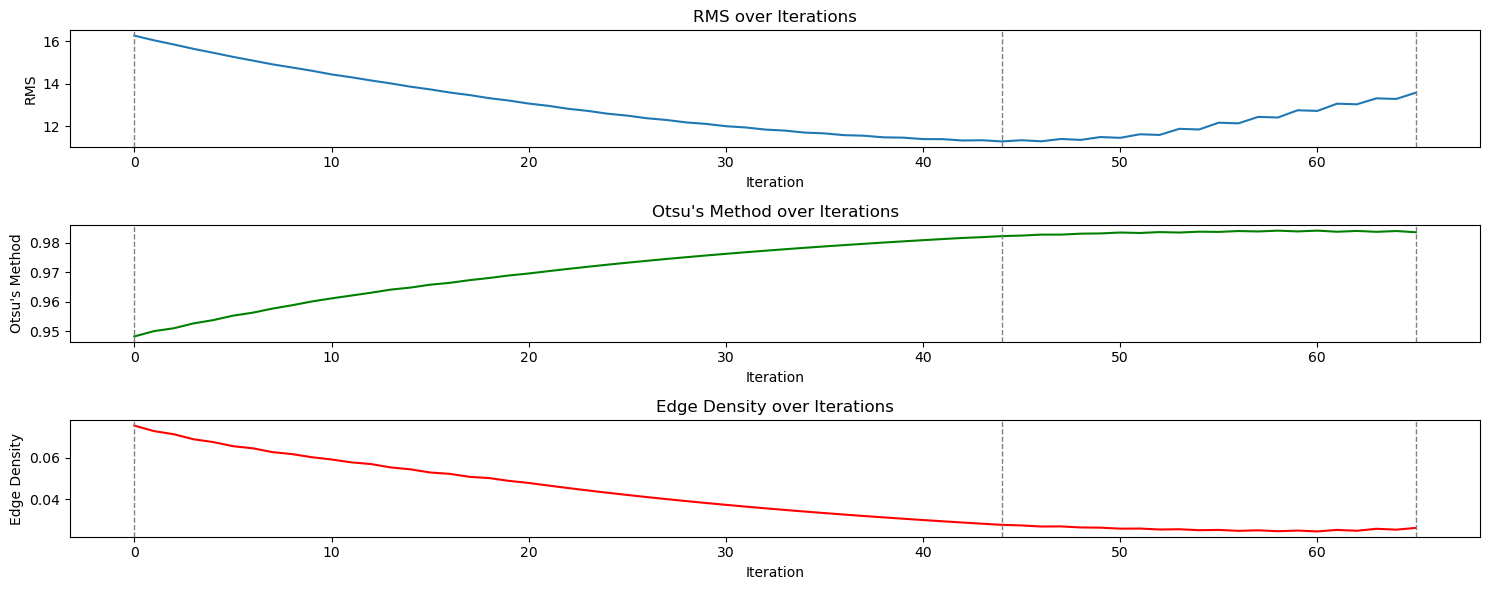

In [5]:
rmss = metrics['rms']
glcms = metrics['glcm']
otsus = metrics['otsus']
edge_densities = metrics['edge_density']

fig, ax = plt.subplots(3, 1, figsize=(15, 6))
ax[0].plot(rmss, label='RMS')
ax[0].set_title('RMS over Iterations')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('RMS')
# ax[0].legend()
ax[1].plot(otsus, label='Otsu\'s Method', color='green')
ax[1].set_title('Otsu\'s Method over Iterations')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Otsu\'s Method')
# ax[2].legend()
ax[2].plot(edge_densities, label='Edge Density', color='red')
ax[2].set_title('Edge Density over Iterations')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Edge Density')
# ax[3].legend()


min_rmss_index = rmss.index(min(rmss))
x = [0, min_rmss_index, len(rmss)-1]

for axis in ax:
    for i in x:
        axis.axvline(x=i, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

### Image

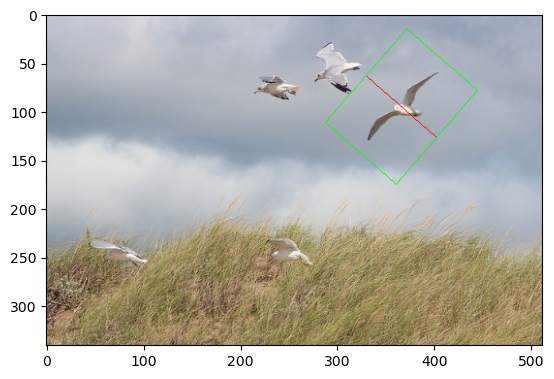

In [6]:
i = 1
row_copy = row.copy()

row_copy['width_box'] += x[i]
row_copy['height_box'] += x[i]

enlarged_box =  cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
display.drawBB(enlarged_box, row_copy)

plt.imshow(enlarged_box)

plt.show()

# Compute Dataset

In [21]:
def compute_biggest_box_dataset(participant_boxes, box_matches, predictions):
    
    box_ids = []
    min_rmss_index = []
    max_rmss_index = []
    # min_glcm_index = []
    # max_glcm_index = []
    # min_otsus_index = []
    # max_otsus_index = []
    # min_edge_density_index = []
    # max_edge_density_index = []

    for _, match in tqdm(box_matches.iterrows(), total=len(box_matches)):
        # Getting row 
        row = participant_boxes.iloc[match['box_id']]
        prediction_id = match['match_id']

        #Getting image
        image_name = row['file_name']
        image = cv2.imread(display.getImgPath(image_name))

        # Skipping boxes outside image
        if is_bbox_outside_image(row, image.shape):
            continue

        # Getting mask
        mask = predictions[image_name].masks[prediction_id].data.cpu().numpy()[0]
        mask = cv2.resize(mask, (predictions[image_name].orig_shape[1], predictions[image_name].orig_shape[0]), interpolation=cv2.INTER_NEAREST).astype(np.uint8)

        # Getting biggest box
        metrics = get_homogeneity_series_rmss_only(mask, row)

        box_ids.append(match['box_id'])
        min_rmss_index.append(metrics['rms'].index(min(metrics['rms'])))
        max_rmss_index.append(metrics['rms'].index(max(metrics['rms'])))
        # min_glcm_index.append(metrics['glcm'].index(min(metrics['glcm'])))
        # max_glcm_index.append(metrics['glcm'].index(max(metrics['glcm'])))
        # min_otsus_index.append(metrics['otsus'].index(min(metrics['otsus'])))
        # max_otsus_index.append(metrics['otsus'].index(max(metrics['otsus'])))
        # min_edge_density_index.append(metrics['edge_density'].index(min(metrics['edge_density'])))
        # max_edge_density_index.append(metrics['edge_density'].index(max(metrics['edge_density'])))
    
    biggest_box = pd.DataFrame({
        'box_id': box_ids,
        'min_rmss_index': min_rmss_index,
        'max_rmss_index': max_rmss_index,
        # 'min_glcm_index': min_glcm_index,
        # 'max_glcm_index': max_glcm_index,
        # 'min_otsus_index': min_otsus_index,
        # 'max_otsus_index': max_otsus_index,
        # 'min_edge_density_index': min_edge_density_index,
        # 'max_edge_density_index': max_edge_density_index
    })

    return biggest_box

compute = False

match_threshold = 0.4
matches = box_matches[box_matches['dice_score'] > match_threshold]
matches = matches[matches['experiment'].isin([3, 4])]

if compute:
    biggest_box = compute_biggest_box_dataset(participant_boxes, matches, results)
    biggest_box.to_csv('data_out/object_detection/biggest_homogeneus_box.csv')
else:
    biggest_box = pd.read_csv('data_out/object_detection/biggest_homogeneus_box.csv', index_col=0)

biggest_box

,box_id,min_rmss_index,max_rmss_index,initial_size,enlarged_size,perc_increase
0,23,20,0,40194.0,51574.0,0.283127
1,26,0,9,71262.0,71262.0,0.000000
2,32,1,12,88816.0,89487.0,0.007555
3,42,1,36,73125.0,73676.0,0.007535
4,48,12,145,28900.0,33124.0,0.146159
...,...,...,...,...,...,...
3976,35116,0,128,24310.0,24310.0,0.000000
3977,35119,7,323,2940.0,3773.0,0.283333
3978,35121,0,224,8316.0,8316.0,0.000000
3979,35127,41,132,17526.0,30072.0,0.715851


## Adding more info to the table

In [22]:
def add_info_biigest_box(biggest_box, participant_boxes):
    initial_size = []
    enlarged_size = []
    perc_increases = []

    for _,box in tqdm(biggest_box.iterrows(), total=len(biggest_box)):
        row = participant_boxes.iloc[int(box['box_id'])]
        initial_size.append(row['width_box'] * row['height_box'])
        enlarged_size.append((row['width_box'] + box['min_rmss_index']) * (row['height_box'] + box['min_rmss_index']))
        perc_increases.append((enlarged_size[-1] - initial_size[-1]) / initial_size[-1])

    biggest_box['initial_size'] = initial_size
    biggest_box['enlarged_size'] = enlarged_size
    biggest_box['perc_increase'] = perc_increases

    return biggest_box

biggest_box = add_info_biigest_box(biggest_box, participant_boxes)
biggest_box.to_csv('data_out/object_detection/biggest_homogeneus_box.csv')

  0%|          | 0/3981 [00:00<?, ?it/s]

100%|██████████| 3981/3981 [00:00<00:00, 16024.71it/s]
